In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import os 
import sys
sys.path.append("..")
from kinematics.class_structure import CHAIN
print("Done.")

Done.


In [10]:

def kernel_se(X1,X2,hyp={'g':1,'l':1}):
    """
        Squared exponential (SE) kernel function
    """
    K = hyp['g']*np.exp(-cdist(X1,X2,'sqeuclidean')/(2*hyp['l']*hyp['l']))
    return K

def kernel_levse(X1,X2,L1,L2,hyp={'g':1,'l':1}):
    """
        Leveraged SE kernel function
    """
    K = hyp['g']*np.exp(-cdist(X1,X2,'sqeuclidean')/(2*hyp['l']*hyp['l']))
    L = np.cos(np.pi/2.0*cdist(L1,L2,'cityblock'))
    return np.multiply(K,L)

def soft_squash(x,x_min=-1,x_max=+1,margin=1.0):
    """
        Soft squashing numpy array
    """
    def th(z,m=0.0):
        # thresholding function 
        return (m)*(np.exp(2/m*z)-1)/(np.exp(2/m*z)+1)
    x_in = np.copy(x)
    idxs_upper = np.where(x_in>(x_max-margin))
    x_in[idxs_upper] = th(x_in[idxs_upper]-(x_max-margin),m=margin) + (x_max-margin)
    idxs_lower = np.where(x_in<(x_min+margin))
    x_in[idxs_lower] = th(x_in[idxs_lower]-(x_min+margin),m=margin) + (x_min+margin)
    return x_in

def soft_squash_multidim(
    x      = np.random.randn(100,5),
    x_min  = -np.ones(5),
    x_max  = np.ones(5),
    margin = 0.1):
    """
        Multi-dim version of 'soft_squash' function
    """
    x_squash = np.copy(x)
    dim      = x.shape[1]
    for d_idx in range(dim):
        x_squash[:,d_idx] = soft_squash(
            x=x[:,d_idx],x_min=x_min[d_idx],x_max=x_max[d_idx],margin=margin)
    return x_squash

class GaussianRandomPathClass(object):
    def __init__(self,
                 name     = 'GRP',
                 kernel   = kernel_levse,
                 hyp_mean = {'g':1.0,'l':1.0,'w':1e-6},
                 hyp_var  = {'g':1.0,'l':1.0,'w':1e-6}
                 ):
        super(GaussianRandomPathClass,self).__init__()
        self.name = name
        # Set kernel
        self.kernel   = kernel     # kernel function
        self.hyp_mean = hyp_mean
        self.hyp_var  = hyp_var
        # Default set data
        self.set_data()
        
    def set_data(self,
                 t_anchor     = np.linspace(start=0.0,stop=1.0,num=10).reshape((-1,1)),
                 x_anchor     = np.zeros((10,2)),
                 l_anchor     = np.ones((10,1)),
                 t_test       = np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)),
                 l_test       = np.ones((100,1)),
                 hyp_mean     = None,
                 hyp_var      = None,
                 w_chol       = 1e-10,     # noise for Cholesky transform
                 APPLY_EPSRU  = False,     # epsilon run-up
                 t_eps        = 0.0001,
                 l_eps        = 1.0,       # leverage for epsilon run-up
                 x_diff_start = None,
                 x_diff_end   = None,
                 SKIP_GP_VAR  = False      # skip GP variance computation
                 ):
        """
            Set anchor data to GRP class
        """
        self.t_anchor    = t_anchor.astype(float)    # [N x 1]
        self.x_anchor    = x_anchor.astype(float)    # [N x D]
        self.t_test      = t_test.astype(float)      # [N_test x 1]
        self.n_anchor    = self.x_anchor.shape[0]
        self.d_anchor    = self.x_anchor.shape[1]
        self.l_anchor    = l_anchor.astype(float)    # [N x 1]
        self.n_test      = self.t_test.shape[0]
        self.l_test      = l_test.astype(float)      # [N_test x 1]
        if hyp_mean is not None: self.hyp_mean = hyp_mean
        if hyp_var is not None: self.hyp_var = hyp_var
            
        # Handle epsilon greedy algorithm
        self.APPLY_EPSRU = APPLY_EPSRU
        self.t_eps       = t_eps
        if self.APPLY_EPSRU:
            # Append runup points
            if (x_diff_start is not None) and (x_diff_end is not None):
                self.x_diff_start = x_diff_start
                self.x_diff_end   = x_diff_end
            else:
                self.x_diff_start = (self.x_anchor[-1,:]-self.x_anchor[0,:]).reshape((1,-1))
                self.x_diff_end = (self.x_anchor[-1,:]-self.x_anchor[0,:]).reshape((1,-1))
            self.t_dur  = (self.t_anchor[-1]-self.t_anchor[0]).squeeze()
            # Append 'x_anchor'
            x_anchor    = self.x_anchor
            x_anchor    = np.insert(x_anchor,1,
                                    x_anchor[0,:]+self.t_eps/self.t_dur*self.x_diff_start,axis=0)
            x_anchor    = np.insert(x_anchor,-1,
                                    x_anchor[-1,:]-self.t_eps/self.t_dur*self.x_diff_end,axis=0)
            n_anchor    = self.x_anchor.shape[0]
            # Append 'x_anchor'
            t_anchor    = self.t_anchor
            t_anchor    = np.insert(t_anchor,1,t_anchor[0,:]+self.t_eps,axis=0)
            t_anchor    = np.insert(t_anchor,-1,t_anchor[-1,:]-self.t_eps,axis=0)
            # Append 'l_anchor'
            l_anchor    = self.l_anchor
            l_eps       = 0.0
            l_anchor    = np.insert(l_anchor,1,l_eps,axis=0)
            l_anchor    = np.insert(l_anchor,-1,l_eps,axis=0)
            # Overwrite 'x_anchor', 't_anchor', 'l_anchor', and 'n_anchor'
            self.x_anchor = x_anchor
            self.t_anchor = t_anchor
            self.n_anchor = self.x_anchor.shape[0]
            if self.kernel.__name__ == 'kernel_levse': # leveraged SE kernel
                self.l_anchor = l_anchor
                
        # GP mean-related
        if self.kernel.__name__ == 'kernel_levse': # leveraged SE kernel
            l_anchor_mean = np.ones((self.n_anchor,1)) # leverage does not affect GP mean
            self.k_test_anchor_mean   = self.kernel(self.t_test,self.t_anchor,
                                                    self.l_test,l_anchor_mean,
                                                    self.hyp_mean)
            self.K_anchor_anchor_mean = self.kernel(self.t_anchor,self.t_anchor,
                                                    l_anchor_mean,l_anchor_mean,
                                                    self.hyp_mean) \
                                        + self.hyp_mean['w']*np.eye(self.n_anchor)
        elif self.kernel.__name__ == 'kernel_se': # SE kernel
            self.k_test_anchor_mean   = self.kernel(self.t_test,self.t_anchor,
                                                    self.hyp_mean)
            self.K_anchor_anchor_mean = self.kernel(self.t_anchor,self.t_anchor,
                                                    self.hyp_mean) \
                                        + self.hyp_mean['w']*np.eye(self.n_anchor)
        else:
            raise TypeError("[GaussianRandomPathClass] Unsupported kernel:[%s]"%
                            (self.kernel.__name__))
        self.x_anchor_mean        = self.x_anchor.mean(axis=0)
        self.gamma_test           = np.linalg.solve(self.K_anchor_anchor_mean,
                                                    self.x_anchor-self.x_anchor_mean)
        self.mean_test            = np.matmul(self.k_test_anchor_mean,self.gamma_test) \
                                    + self.x_anchor_mean
        
        # GP variance-related
        self.SKIP_GP_VAR = SKIP_GP_VAR
        if self.SKIP_GP_VAR: return # skip in case of computing the mean only 
        if self.kernel.__name__ == 'kernel_levse': # leveraged SE kernel
            self.k_test_test_var     = self.kernel(self.t_test,self.t_test,
                                                   self.l_test,self.l_test,
                                                   self.hyp_var)
            self.k_test_anchor_var   = self.kernel(self.t_test,self.t_anchor,
                                                   self.l_test,self.l_anchor,
                                                   self.hyp_var)
            self.K_anchor_anchor_var = self.kernel(self.t_anchor,self.t_anchor,
                                                   self.l_anchor,self.l_anchor,
                                                   self.hyp_var) \
                                        + self.hyp_mean['w']*np.eye(self.n_anchor)
        elif self.kernel.__name__ == 'kernel_se': # SE kernel
            self.k_test_test_var     = self.kernel(self.t_test,self.t_test,
                                                   self.hyp_var)
            self.k_test_anchor_var   = self.kernel(self.t_test,self.t_anchor,
                                                   self.hyp_var)
            self.K_anchor_anchor_var = self.kernel(self.t_anchor,self.t_anchor,
                                                   self.hyp_var) \
                                        + self.hyp_mean['w']*np.eye(self.n_anchor)
        else:
            raise TypeError("[GaussianRandomPathClass] Unsupported kernel:[%s]"%
                            (self.kernel.__name__))
        self.var_test            = self.k_test_test_var - np.matmul(self.k_test_anchor_var,
            np.linalg.solve(self.K_anchor_anchor_var,self.k_test_anchor_var.T))
        self.var_diag_test       = np.diag(self.var_test).reshape((-1,1))
        self.std_diag_test       = np.sqrt(self.var_diag_test)
        self.w_chol              = w_chol
        self.var_chol_test       = np.linalg.cholesky(self.var_test \
                                                      + self.w_chol*np.eye(self.n_test))
            
    def sample(self,
               n_sample  = 10,
               rand_type = 'Gaussian',
               x_min  = -0.4, 
               x_max  = 0.4, 
               margin = 0.1,
               SQUASH  = True):
        """
            Sample from GRP
        """
        samples = []
        for s_idx in range(n_sample):
            if rand_type == 'Gaussian':
                R = np.random.randn(self.n_test,self.d_anchor)
            elif rand_type == 'Uniform':
                rand_gain = 3 # -gain ~ +gain
                R = rand_gain*(2*np.random.rand(self.n_test,self.d_anchor)-1)
            else:
                raise TypeError("[GaussianRandomPathClass] Unsupported rand_type:[%s]"%(rand_type))
            sample = self.mean_test+np.matmul(self.var_chol_test,R)
            if SQUASH:
                sample = soft_squash(sample,x_min=x_min,x_max=x_max,margin=margin)
            samples.append(sample)
        return samples,self.t_test

    def mean_traj(self,
                  x_min  = -0.4, 
                  x_max  = 0.4, 
                  margin = 0.1,
                  SQUASH  = True):
        sample       = self.mean_test
        if SQUASH:
            exploit_traj = soft_squash(sample,x_min=x_min,x_max=x_max,margin=margin)
        else:
            exploit_traj = sample
        return exploit_traj, self.t_test

    def generate_random_anchors_w_init(self, num_anchor=2, 
                                             first_anchor=0, 
                                             last_anchor=0., 
                                             t_test=np.linspace(start=0.6,stop=1.0,num=10).reshape((-1,1))):

        x_anchors = np.random.uniform(low=-0.4, high=0.4, size=num_anchor)
        x_anchors = np.insert(x_anchors, 0, first_anchor) # Add a first anchor
        x_anchors = np.insert(x_anchors,len(x_anchors),last_anchor) # Add a last anchor

        n_test = len(t_test)
        idxs = np.round(np.linspace(start=0,stop=n_test-1,num=len(x_anchors))).astype(np.int16)
        t_anchors = t_test[idxs]
        return x_anchors, t_anchors

    def get_anchors_from_traj(self, t_test,traj,n_anchor=6):
        """
        Get equidist anchors from a trajectory
        """
        n_test = len(t_test)
        idxs = np.round(np.linspace(start=0,stop=n_test-1,num=n_anchor)).astype(np.int16)
        t_anchor,x_anchor = t_test[idxs],traj[idxs]
        return t_anchor,x_anchor

    def plot(self,
             n_sample  = 10,
             figsize   = (6,3),
             lw_sample = 1/4,
             ylim      = None,
             title_str = None,
             tfs       = 15,
             rand_type = 'Gaussian'):
        """
            Plot GRP
        """
        sampled_trajs,t_test = self.sample(n_sample=n_sample,rand_type=rand_type)
        colors = [plt.cm.Set1(i) for i in range(self.d_anchor)]
        for d_idx in range(self.d_anchor):
            color = colors[d_idx]
            plt.figure(figsize=figsize)
            # Plot sampled trajectories
            for s_idx in range(len(sampled_trajs)):
                sampled_traj = sampled_trajs[s_idx]
                plt.plot(self.t_test,sampled_traj[:,d_idx],'-',color='k',lw=lw_sample)
            # Plot mean
            plt.plot(self.t_test,self.mean_test[:,d_idx],'-',color=color,lw=3)
            # Plot anchors
            plt.plot(self.t_anchor,self.x_anchor[:,d_idx],'o',mfc='none',ms=10,mec='k')
            # Plot 2-standard deviation (95%)
            plt.fill_between(self.t_test.squeeze(),
                             self.mean_test[:,d_idx]-2*self.std_diag_test.squeeze(),
                             self.mean_test[:,d_idx]+2*self.std_diag_test.squeeze(),
                             facecolor=color,interpolate=True,alpha=0.2)
            if ylim is not None:
                plt.ylim(ylim)
            if title_str is None:
                plt.title("Dim-[%d]"%(d_idx),fontsize=tfs)
            else:
                plt.title("%s"%(title_str),fontsize=tfs)
            plt.show()

    def interpolation(self, x_anchor, num_interpol):
        for anchor_idx in range(len(x_anchor)):
            if (anchor_idx+1) == len(x_anchor):
                break
            interpoled_x = np.linspace(x_anchor[anchor_idx], x_anchor[anchor_idx+1], num_interpol)
            if anchor_idx ==0:
                interpoled_x_arr = interpoled_x
            else:
                interpoled_x_arr = np.append(interpoled_x_arr, interpoled_x, axis=0)
        return interpoled_x_arr


class RobotClass(object):
    def __init__(self, file_name, base_offset):
        super(RobotClass,self).__init__() 
        self.chain = CHAIN(file_name=file_name, base_offset=base_offset)
        self.chain.add_joi_to_robot()
        self.chain.add_link_to_robot()
        self.chain.fk_chain(1)
    
    def solve_ik(self,  target_name      = ['wrist_3_joint'],
                        target_position  = [[0,0,0]],
                        target_rotation  = [[-1.57, 0, -1.57]],
                        solve_position   = [1],
                        solve_rotation   = [1],
                        weight_position  = 1,
                        weight_rotation  = 1,
                        joi_ctrl_num= 6): 
                        
        ingredients = self.make_ik_input(target_name = target_name,
                                    target_pos  = target_position,
                                    target_rot  = target_rotation,
                                    solve_pos   = solve_position,
                                    solve_rot   = solve_rotation,
                                    weight_pos  = weight_position,
                                    weight_rot  = weight_rotation,
                                    joi_ctrl_num= joi_ctrl_num)
        total_q = self.chain.get_q_from_ik(ingredients)
        ctrl_q  = total_q[:joi_ctrl_num+1] #Including base joint for Unity Env
        ctrl_q  = ctrl_q.reshape(-1,)
        return ctrl_q 

    def make_ik_input(self, target_name=["base_joint"], 
                    target_pos=[[0, 0, 0]], 
                    target_rot=[[0, 0, 0]], 
                    solve_pos=[1], 
                    solve_rot=[1], 
                    weight_pos=1, 
                    weight_rot=0, 
                    disabled_joi_id=[], 
                    joi_ctrl_num=7):
        return {"target_joint_name":target_name, 
                "target_joint_position":target_pos,
                "target_joint_rotation":target_rot,
                "solve_position":solve_pos,
                "solve_rotation":solve_rot,
                "position_weight":weight_pos,
                "rotation_weight":weight_rot,
                "disabled_joi_id":disabled_joi_id, 
                "joint_ctrl_num":joi_ctrl_num}

### Prior

t_test_anchor from prior trajectory [[0.62631579 0.77368421]]
x_anchor from prior trajectory [[ 0.17412486 -0.13918099]]


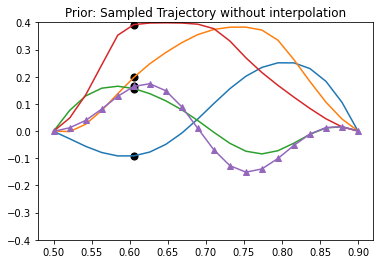

In [14]:
grp = GaussianRandomPathClass(name = 'GRP',kernel = kernel_se)
last_position = 0
t_test        = np.linspace(start=0.5,stop=0.9,num=20).reshape((-1,1))
x_anchor1     = np.array([0, last_position])

total_anchor_num = len(x_anchor1)
grp.set_data(t_anchor    = np.linspace(start=0.5,stop=0.9,num=total_anchor_num).reshape((-1,1)),
           x_anchor    = np.array([x_anchor1]).T,
           t_test      = t_test,
           hyp_mean    = {'g':0.07,'l':0.1,'w':1e-6},
           hyp_var     = {'g':0.07,'l':0.1,'w':1e-6},
           APPLY_EPSRU = False,
          )
sel_idx = np.random.randint(low=0, high=5)
trajs, t_test = grp.sample(n_sample=5)
t_test_anchor, x_anchor = grp.get_anchors_from_traj(t_test,trajs[sel_idx],n_anchor=4)
print("t_test_anchor from prior trajectory", t_test_anchor[1:-1].T)
print("x_anchor from prior trajectory", x_anchor[1:-1].T)

for idx, traj in enumerate(trajs):
       plt.ylim(-0.4,0.4)
       plt.title("Prior: Sampled Trajectory without interpolation")
       if idx == sel_idx: # Selected trajectory
              plt.plot(t_test,traj,'-^')
       else:
              plt.plot(t_test,traj,'-')
       plt.scatter(t_test[5], traj[5], color="k", s=50)

In [13]:
file_name = "../urdf/ur5e/ur5e_onrobot.urdf"
base_offset = [0,0,0]
robot     = RobotClass(file_name=file_name, base_offset=base_offset)
q         = robot.solve_ik(target_name = ['wrist_3_joint', 'gripper_finger1_finger_tip_joint'],
            target_position  = [[0.2,0,0.6], [0.2+0.15,0,0.6]],
            target_rotation  = [[0, 3.14, -1.57],[0,0,0]],
            solve_position   = [1, 1],
            solve_rotation   = [1, 0],
            weight_position  = 1,
            weight_rotation  = 1,
            joi_ctrl_num= 6)
print(q)

[ 0.         -1.2363211  -2.26643127  1.71015579  0.55702988  0.31529247
 -0.00256432]


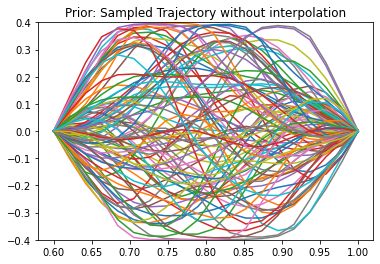

In [17]:
grp = GaussianRandomPathClass(name = 'GRP',kernel = kernel_se)
last_position = 0
t_test        = np.linspace(start=0.6,stop=1.0,num=20).reshape((-1,1))
x_anchor1     = np.array([0, last_position])

total_anchor_num = len(x_anchor1)
grp.set_data(t_anchor    = np.linspace(start=0.6,stop=1.0,num=total_anchor_num).reshape((-1,1)),
           x_anchor    = np.array([x_anchor1]).T,
           t_test      = t_test,
           hyp_mean    = {'g':0.06,'l':0.1,'w':1e-6},
           hyp_var     = {'g':0.06,'l':0.1,'w':1e-6},
           APPLY_EPSRU = False,
          )
trajs, t_test = grp.sample(n_sample=100)

for idx, traj in enumerate(trajs):
       plt.ylim(-0.4,0.4)
       plt.title("Prior: Sampled Trajectory without interpolation")
       plt.plot(t_test,traj,'-')
